In [3]:
import pandas as pd

In [299]:
res = pd.read_csv('results_n_steps_50_shell.csv').dropna()

In [300]:
res = res[res['activation'] == 'relu']

In [301]:
res_mapping = {
    'geodesic_integrated_gradients_5': 'GeodesicIntegratedGradients (kNN)',
       'enhanced_integrated_gradients_5': 'EnhancedIntegratedGradients (kNN)',
    'gradient_shap': 'GradientShap',
       'integrated_gradients':'IntegratedGredients', 
       'input_x_gradient':'InputXGradient', 'kernel_shap':'KernelShap',
       'svi_integrated_gradients_li_False_em_False': 'GeodesicIntegratedGradients (SVI)',
       'guided_integrated_gradients':'GuidedIntegratedGradients', 
       'occlusion':'Occlusion', 
       'random':'Random',
}

In [302]:
res = res[~res['method'].isin(['LIME', 'AugmentedOcclusion'])]
# res = res.groupby(['noise', 'method']).mean().reset_index()
res['method'] = res['method'].map(res_mapping)

In [303]:
res.columns

Index(['seed', 'noise', 'activation', 'method', 'purity', 'std_0', 'std_1'], dtype='object')

In [304]:
res.dropna(inplace=True)
res['method'].unique()

array(['GeodesicIntegratedGradients (kNN)',
       'EnhancedIntegratedGradients (kNN)', 'GradientShap',
       'IntegratedGredients', 'InputXGradient', 'KernelShap',
       'GeodesicIntegratedGradients (SVI)', 'GuidedIntegratedGradients',
       'Occlusion', 'Random'], dtype=object)

In [305]:
# sub_res = res[res['method'].isin(["geodesic_integrated_gradients_5",
#                                 "enhanced_integrated_gradients_5",
#                                 "gradient_shap", "kernel_shap",
#                                 "occlusion", "input_x_gradient",
#                                 "integrated_gradients", "augmented_occlusion",
#                                 "svi_integrated_gradients_li_False_em_False",
#                                 "random", "guided_integrated_gradients",])]

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Use a color-blind friendly palette with distinct colors
auc_values = {}
colors = sns.color_palette("husl", n_colors=len(res['method'].unique()))
markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X', 'p', 'h', 'H']

plt.figure(figsize=(12, 6))

# Calculate AUC and plot each method
for idx, method in enumerate(res['method'].unique()):
    method_data = res[res['method'] == method]
    x = method_data['noise'].values
    y = method_data['purity'].values
    
    # Calculate AUC using trapezoidal rule
    auc = np.trapz(y, x)
    auc_values[method] = auc
    
    # Sort methods by AUC
    sorted_methods = dict(sorted(auc_values.items(), key=lambda x: x[1], reverse=True))

# Plot with sorted methods
for idx, (method, auc) in enumerate(sorted_methods.items()):
    method_data = res[res['method'] == method]
    plt.plot(method_data['noise'], method_data['purity'], 
             color=colors[idx], 
             marker=markers[idx % len(markers)],
             markersize=10,
             linewidth=2,
             label=f'{method} (AUC={auc:.3f})')

plt.title('Purity vs Noise by Method', fontsize=12)
plt.xlabel('Noise Level', fontsize=11)
plt.ylabel('Purity', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(title='Method', loc='upper left', 
          fontsize=10)

plt.tight_layout()
plt.show()

NameError: name 'res' is not defined

In [307]:
import scipy.stats as stats

# First, identify numeric columns
numeric_cols = res.select_dtypes(include=['float64', 'int64']).columns

# First check samples per group
sample_sizes = res.groupby(['noise', 'method']).size()
print("Samples per group:\n", sample_sizes)

# Modified aggregation with error handling
def safe_sem(x):
    if len(x) <= 1:
        return float('nan')  # or return 0, depending on your needs
    return stats.sem(x)

# Apply aggregation with safe SE calculation
agg_dict = {}
for col in numeric_cols:
    agg_dict[col] = ['mean', safe_sem]

res_stats = (res.groupby(['noise', 'method'])
             .agg(agg_dict)
             .reset_index())

# Flatten column names
res_stats.columns = [f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col 
                    for col in res_stats.columns]
res_stats.columns = [col.replace('<lambda>', 'se') for col in res_stats.columns]

Samples per group:
 noise  method                           
0.05   EnhancedIntegratedGradients (kNN)    5
       GeodesicIntegratedGradients (SVI)    5
       GeodesicIntegratedGradients (kNN)    5
       GradientShap                         5
       GuidedIntegratedGradients            5
                                           ..
0.65   InputXGradient                       5
       IntegratedGredients                  5
       KernelShap                           5
       Occlusion                            5
       Random                               5
Length: 130, dtype: int64


In [308]:
res_stats

,noise_,method_,seed_mean,seed_safe_sem,noise_mean,noise_safe_sem,purity_mean,purity_safe_sem,std_0_mean,std_0_safe_sem,std_1_mean,std_1_safe_sem
0,0.05,EnhancedIntegratedGradients (kNN),36.0,8.485281,0.05,0.0,0.98896,0.005224,0.025099,0.007704,0.000708,0.000284
1,0.05,GeodesicIntegratedGradients (SVI),36.0,8.485281,0.05,0.0,0.93616,0.032414,25.018000,3.559550,12.148200,0.937547
2,0.05,GeodesicIntegratedGradients (kNN),36.0,8.485281,0.05,0.0,0.98896,0.005224,0.000261,0.000144,0.000296,0.000102
3,0.05,GradientShap,36.0,8.485281,0.05,0.0,0.95984,0.016043,10.059600,1.425442,4.577200,0.188746
4,0.05,GuidedIntegratedGradients,36.0,8.485281,0.05,0.0,0.89920,0.044845,0.312826,0.150002,0.392180,0.153727
...,...,...,...,...,...,...,...,...,...,...,...,...
125,0.65,InputXGradient,36.0,8.485281,0.65,0.0,0.60192,0.016235,0.398220,0.020520,0.423820,0.018073
126,0.65,IntegratedGredients,36.0,8.485281,0.65,0.0,0.76048,0.035990,0.435560,0.021291,0.503940,0.014848
127,0.65,KernelShap,36.0,8.485281,0.65,0.0,0.76800,0.039475,0.409000,0.013418,0.445960,0.015182
128,0.65,Occlusion,36.0,8.485281,0.65,0.0,0.79616,0.052848,0.533360,0.041258,0.372740,0.025671


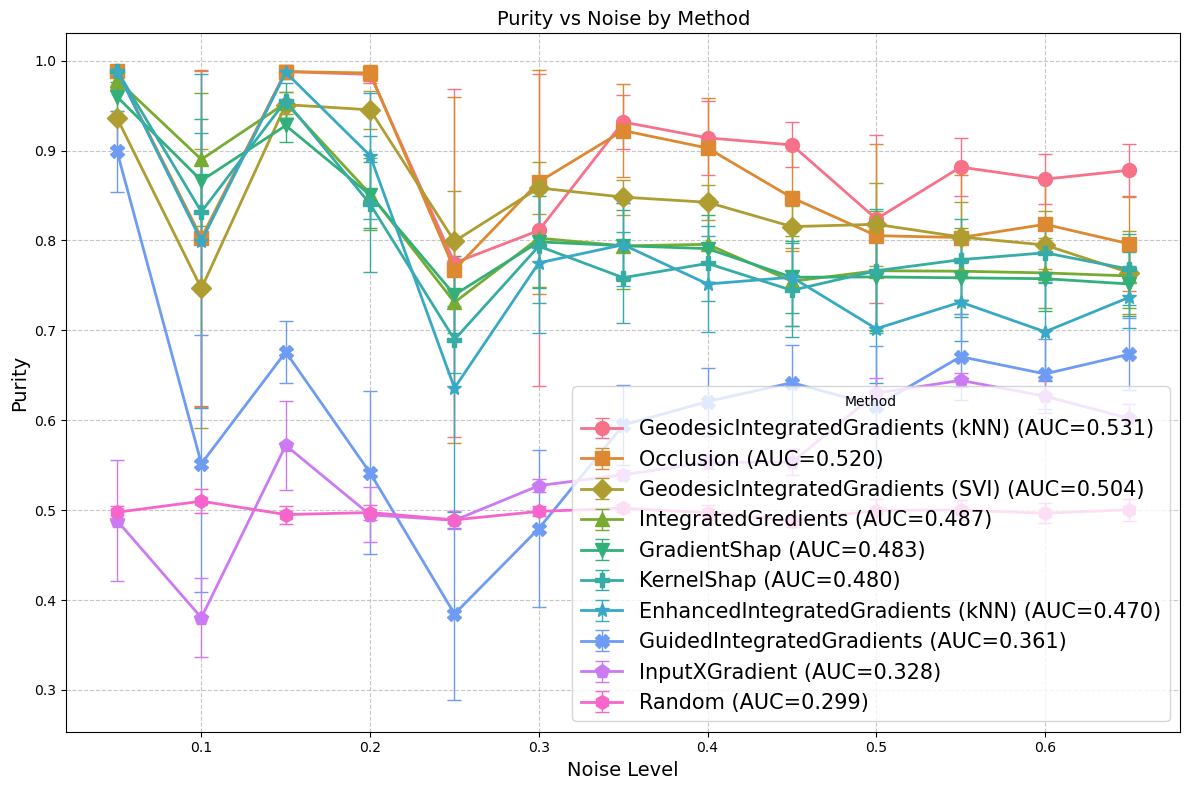

In [310]:
auc_values = {}
colors = sns.color_palette("husl", n_colors=len(res_stats['method_'].unique()))
markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X', 'p', 'h', 'H']

plt.figure(figsize=(12, 8))

# Calculate AUC and plot each method
for idx, method in enumerate(res_stats['method_'].unique()):
    method_data = res_stats[res_stats['method_'] == method]
    x = method_data['noise_mean'].values
    y = method_data['purity_mean'].values
    y_err = method_data['purity_safe_sem'].values
    
    # Calculate AUC using trapezoidal rule
    auc = np.trapz(y, x)
    auc_values[method] = auc

# Sort methods by AUC
sorted_methods = dict(sorted(auc_values.items(), key=lambda x: x[1], reverse=True))

# Plot with sorted methods and error bars
for idx, (method, auc) in enumerate(sorted_methods.items()):
    method_data = res_stats[res_stats['method_'] == method]
    plt.errorbar(method_data['noise_mean'], method_data['purity_mean'],
                yerr=method_data['purity_safe_sem'],
                color=colors[idx],
                marker=markers[idx % len(markers)],
                markersize=10,
                linewidth=2,
                label=f'{method} (AUC={auc:.3f})',
                capsize=5,
                capthick=1,
                elinewidth=1)

plt.title('Purity vs Noise by Method', fontsize=14)
plt.xlabel('Noise Level', fontsize=14)
plt.ylabel('Purity', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Method', loc='lower right', fontsize=15)
plt.tight_layout()
plt.show()

In [155]:
res.method.unique()

array(['augmented_occlusion', 'enhanced_integrated_gradients_10',
       'enhanced_integrated_gradients_15',
       'enhanced_integrated_gradients_5',
       'geodesic_integrated_gradients_10',
       'geodesic_integrated_gradients_15',
       'geodesic_integrated_gradients_5', 'gradient_shap',
       'guided_integrated_gradients', 'input_x_gradient',
       'integrated_gradients', 'kernel_shap', 'occlusion', 'random',
       'svi_integrated_gradients_li_False_em_False',
       'svi_integrated_gradients_li_False_em_True',
       'svi_integrated_gradients_li_True_em_False',
       'svi_integrated_gradients_li_True_em_True'], dtype=object)

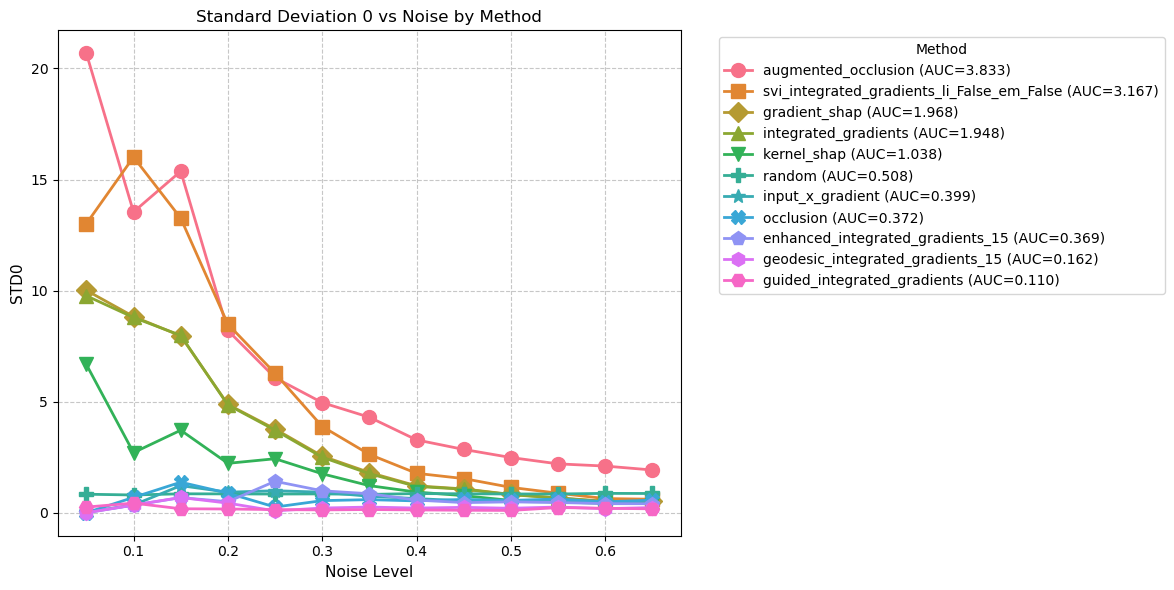

In [158]:
# Use a color-blind friendly palette with distinct colors
auc_values = {}
colors = sns.color_palette("husl", n_colors=len(sub_res['method'].unique()))
markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X', 'p', 'h', 'H']

plt.figure(figsize=(12, 6))

# Calculate AUC and plot each method
for idx, method in enumerate(sub_res['method'].unique()):
    method_data = sub_res[sub_res['method'] == method]
    x = method_data['noise'].values
    y = method_data['std_0'].values
    
    # Calculate AUC using trapezoidal rule
    auc = np.trapz(y, x)
    auc_values[method] = auc
    
    # Sort methods by AUC
    sorted_methods = dict(sorted(auc_values.items(), key=lambda x: x[1], reverse=True))

# Plot with sorted methods
for idx, (method, auc) in enumerate(sorted_methods.items()):
    method_data = sub_res[sub_res['method'] == method]
    plt.plot(method_data['noise'], method_data['std_0'], 
             color=colors[idx], 
             marker=markers[idx % len(markers)],
             markersize=10,
             linewidth=2,
             label=f'{method} (AUC={auc:.3f})')

plt.title('Standard Deviation 0 vs Noise by Method', fontsize=12)
plt.xlabel('Noise Level', fontsize=11)
plt.ylabel('STD0', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left', 
          fontsize=10)

plt.tight_layout()
plt.show()

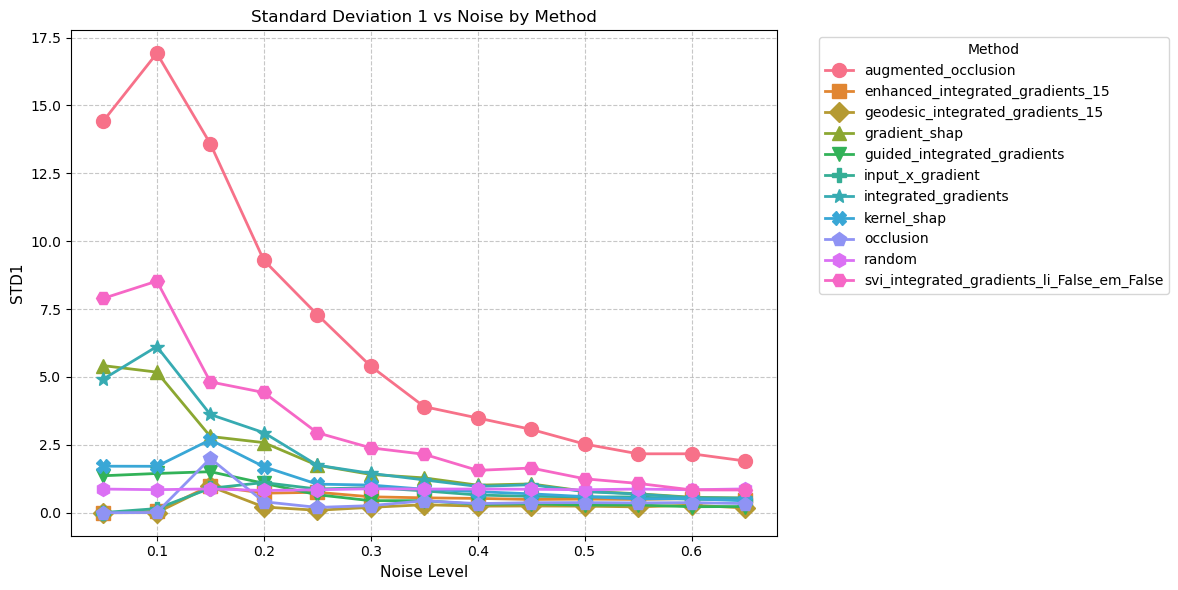

In [134]:
# Use a color-blind friendly palette with distinct colors
colors = sns.color_palette("husl", n_colors=len(sub_res['method'].unique()))
markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X', 'p', 'h', 'H']

plt.figure(figsize=(12, 6))
# Plot each method separately to ensure markers appear in legend
for idx, method in enumerate(sub_res['method'].unique()):
    method_data = sub_res[sub_res['method'] == method]
    plt.plot(method_data['noise'], method_data['std_1'], 
             color=colors[idx], 
             marker=markers[idx % len(markers)],
             markersize=10,
             linewidth=2,
             label=method)

plt.title('Standard Deviation 1 vs Noise by Method', fontsize=12)
plt.xlabel('Noise Level', fontsize=11)
plt.ylabel('STD1', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left', 
          fontsize=10)

plt.tight_layout()
plt.show()

In [135]:
# VOC experiment

In [4]:
res_voc = pd.read_csv('experiments/voc/results/results-2025-01-21.csv')

In [5]:
noises = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65]

In [6]:
res_voc = res_voc[res_voc['noise'].isin(noises)]

In [7]:
res_voc

,seed,augmented,noise,method,model,acc_comp,acc_suff,comp,ce_comp,ce_suff,l_odds,suff,none,none.1
20,42,zeros,0.05,kernel_shap_convnext_base,convnext_base,0.860,0.130,0.07632,0.5879,7.164,-0.4928,0.7985,None,None
21,42,zeros,0.05,gradient_shap_convnext_base,convnext_base,0.850,0.080,0.08666,0.7911,5.765,-0.6959,0.8259,None,None
22,42,zeros,0.05,integrated_gradients_convnext_base,convnext_base,0.830,0.180,0.09995,0.8662,4.339,-0.7711,0.7241,None,None
23,42,zeros,0.05,guided_integrated_gradients_convnext_base,convnext_base,0.820,0.100,0.12680,1.0090,5.345,-0.9143,0.8130,None,None
24,42,zeros,0.05,svi_integrated_gradients_convnext_base_True_Fa...,convnext_base,0.760,0.180,0.18880,0.9851,3.651,-0.8900,0.7088,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,42,aug,0.65,input_x_gradient_convnext_base,convnext_base,0.148,0.397,0.79500,8.2500,4.581,-7.8960,0.5247,None,None
296,42,aug,0.65,lime_convnext_base,convnext_base,0.101,0.360,0.83070,9.9760,6.142,-10.2600,0.5919,None,None
297,42,aug,0.65,augmented_occlusion_convnext_base,convnext_base,0.120,0.469,0.82270,8.8370,3.835,-9.0500,0.4711,None,None
298,42,aug,0.65,occlusion_convnext_base,convnext_base,0.121,0.465,0.81760,9.2050,3.308,-9.1510,0.4782,None,None


In [8]:
res_voc = res_voc[res_voc['augmented'] == 'zeros']

In [9]:
method_mapping = {
    'kernel_shap_convnext_base':'KernelSHAP',
    'gradient_shap_convnext_base':'GradientSHAP',
       'integrated_gradients_convnext_base':'IntegratedGradients',
       'guided_integrated_gradients_convnext_base':'GuidedIntegratedGradients',
       'svi_integrated_gradients_convnext_base_True_False_500_50_0.1_0.01_True':'GeodesicIntegratedGradients (SVI)',
       'input_x_gradient_convnext_base':'InputXGradient',
        'lime_convnext_base':'LIME',
       'augmented_occlusion_convnext_base':'AugmentedOcclusion', 
       'occlusion_convnext_base':'Occlusion',
       'random_convnext_base':'Random',}

In [10]:
res_voc['method'] = res_voc['method'].map(method_mapping)
res_voc = res_voc[~res_voc['method'].isin(['LIME', 'AugmentedOcclusion'])]
res_voc['method'].unique()

/var/folders/lg/hgh4cdg13gx17kzysnjflhrw0000gn/T/ipykernel_99286/1464819178.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_voc['method'] = res_voc['method'].map(method_mapping)


array(['KernelSHAP', 'GradientSHAP', 'IntegratedGradients',
       'GuidedIntegratedGradients', 'GeodesicIntegratedGradients (SVI)',
       'InputXGradient', 'Occlusion', 'Random'], dtype=object)

In [11]:
def calculate_area(x, y):
    # For negative values, calculate area between y=0 and curve
    # For positive values, calculate area under curve
    zero_line = np.zeros_like(y)
    area = np.trapz(np.where(y < 0, -y, y), x)
    return area

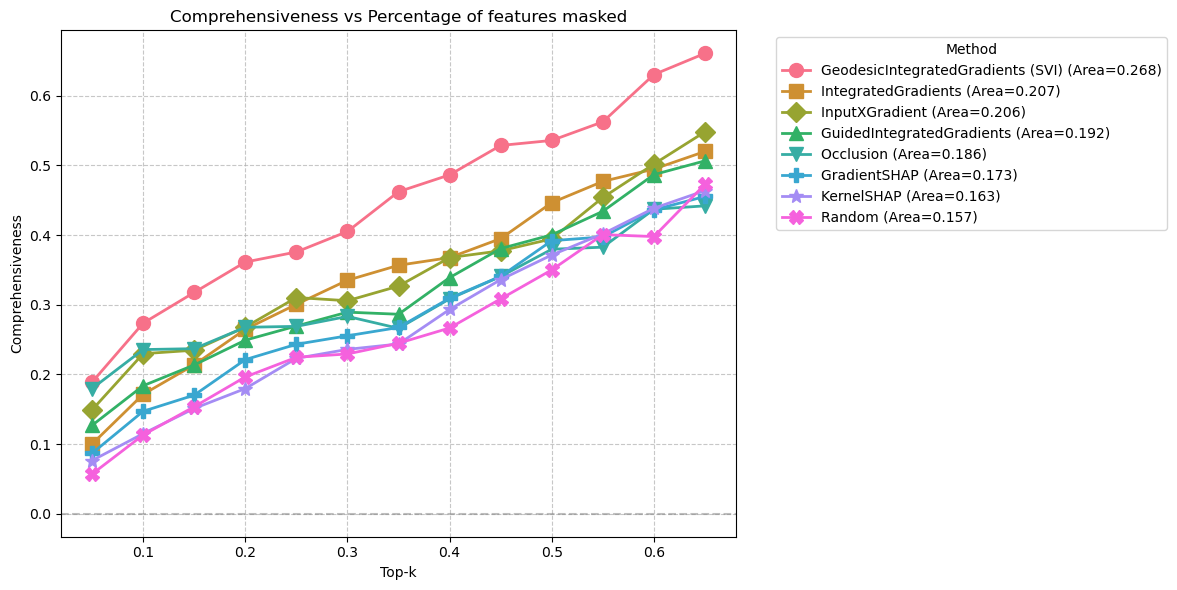

In [15]:
auc_values = {}
colors = sns.color_palette("husl", n_colors=len(res_voc['method'].unique()))
markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X', 'p', 'h']

plt.figure(figsize=(12, 6))

# Add y=0 reference line
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# Calculate areas and plot
for idx, method in enumerate(res_voc['method'].unique()):
    method_data = res_voc[res_voc['method'] == method]
    x = method_data['noise'].values
    y = method_data['comp'].values
    
    area = calculate_area(x, y)
    auc_values[method] = area

# Sort and plot
sorted_methods = dict(sorted(auc_values.items(), key=lambda x: x[1], reverse=True))

for idx, (method, area) in enumerate(sorted_methods.items()):
    method_data = res_voc[res_voc['method'] == method]
    plt.plot(method_data['noise'], method_data['comp'], 
             color=colors[idx], 
             marker=markers[idx % len(markers)],
             markersize=10,
             linewidth=2,
             label=f'{method} (Area={area:.3f})')

plt.title('Comprehensiveness vs Percentage of features masked')
plt.xlabel('Top-k')
plt.ylabel('Comprehensiveness')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

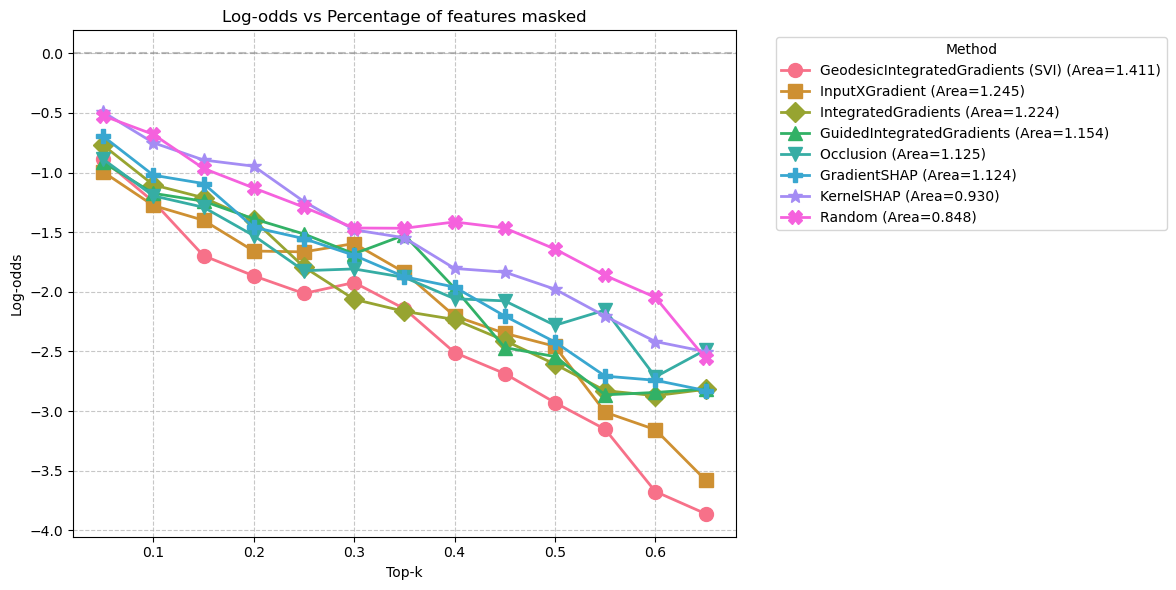

In [16]:
plt.figure(figsize=(12, 6))

# Add y=0 reference line
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# Calculate areas and plot
for idx, method in enumerate(res_voc['method'].unique()):
    method_data = res_voc[res_voc['method'] == method]
    x = method_data['noise'].values
    y = method_data['l_odds'].values
    
    area = calculate_area(x, y)
    auc_values[method] = area

# Sort and plot
sorted_methods = dict(sorted(auc_values.items(), key=lambda x: x[1], reverse=True))

for idx, (method, area) in enumerate(sorted_methods.items()):
    method_data = res_voc[res_voc['method'] == method]
    plt.plot(method_data['noise'], method_data['l_odds'], 
             color=colors[idx], 
             marker=markers[idx % len(markers)],
             markersize=10,
             linewidth=2,
             label=f'{method} (Area={area:.3f})')

plt.title('Log-odds vs Percentage of features masked')
plt.xlabel('Top-k')
plt.ylabel('Log-odds')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

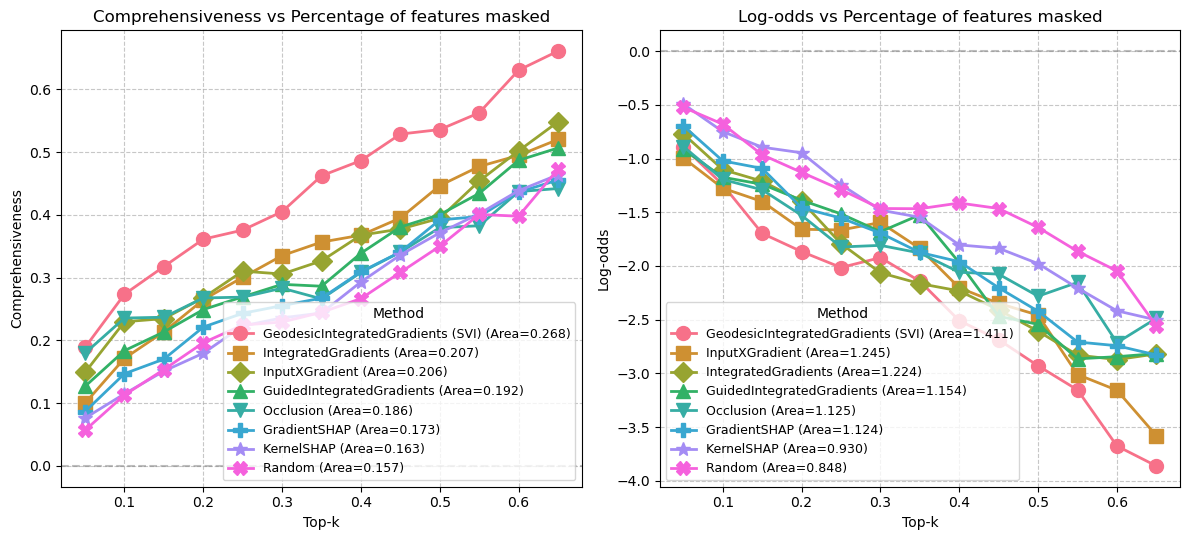

In [23]:
# Setup figure with two subplots vertically stacked
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5.5))

# Color palette and markers
colors = sns.color_palette("husl", n_colors=len(res_voc['method'].unique()))
markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X', 'p', 'h']

# First subplot - Comprehensiveness
auc_values = {}
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

for idx, method in enumerate(res_voc['method'].unique()):
    method_data = res_voc[res_voc['method'] == method]
    x = method_data['noise'].values
    y = method_data['comp'].values
    
    area = calculate_area(x, y)
    auc_values[method] = area

sorted_methods = dict(sorted(auc_values.items(), key=lambda x: x[1], reverse=True))

for idx, (method, area) in enumerate(sorted_methods.items()):
    method_data = res_voc[res_voc['method'] == method]
    ax1.plot(method_data['noise'], method_data['comp'], 
             color=colors[idx], 
             marker=markers[idx % len(markers)],
             markersize=10,
             linewidth=2,
             label=f'{method} (Area={area:.3f})')

ax1.set_title('Comprehensiveness vs Percentage of features masked')
ax1.set_xlabel('Top-k')
ax1.set_ylabel('Comprehensiveness')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(title='Method', loc='lower right', fontsize=9)

# Second subplot - Log-odds
auc_values = {}
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

for idx, method in enumerate(res_voc['method'].unique()):
    method_data = res_voc[res_voc['method'] == method]
    x = method_data['noise'].values
    y = method_data['l_odds'].values
    
    area = calculate_area(x, y)
    auc_values[method] = area

sorted_methods = dict(sorted(auc_values.items(), key=lambda x: x[1], reverse=True))

for idx, (method, area) in enumerate(sorted_methods.items()):
    method_data = res_voc[res_voc['method'] == method]
    ax2.plot(method_data['noise'], method_data['l_odds'], 
             color=colors[idx], 
             marker=markers[idx % len(markers)],
             markersize=10,
             linewidth=2,
             label=f'{method} (Area={area:.3f})')

ax2.set_title('Log-odds vs Percentage of features masked')
ax2.set_xlabel('Top-k')
ax2.set_ylabel('Log-odds')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend(title='Method', loc='lower left', fontsize=9)

plt.tight_layout()
plt.show()